In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import joblib
import re
import warnings
warnings.filterwarnings("ignore")

c:\Users\Asus\anaconda3\envs\vedbot\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_huggingface import HuggingFaceEmbeddings


# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
df = pd.read_excel(r"C:\\Users\\Asus\\Downloads\\symptoms_cleaned.xlsx")

# Select symptom columns (multi-language)
symptom_cols = ['sanskrit','marathi','hindi','english']

# Melt into single column dataset
combined = pd.melt(
    df,
    id_vars=['super_category','category','sub_category'],
    value_vars=symptom_cols,
    var_name='language',
    value_name='symptom'
).dropna(subset=['symptom'])

X = combined['symptom']
y_cat = combined['category']
y_sub = combined['sub_category']
y_super= combined['super_category']

# ---------------------------------------------------------
# 2. LABEL ENCODERS
# ---------------------------------------------------------
enc_cat = LabelEncoder()
enc_sub = LabelEncoder()
enc_super= LabelEncoder()

y_cat = enc_cat.fit_transform(y_cat)
y_sub = enc_sub.fit_transform(y_sub)
y_super = enc_super.fit_transform(y_super)

# ---------------------------------------------------------
# 3. MULTILINGUAL EMBEDDINGS
# ---------------------------------------------------------
embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
X_emb = embedder.embed_documents(X.tolist())




In [3]:
# ---------------------------------------------------------
# 4. TRAIN/TEST SPLIT
# ---------------------------------------------------------
X_train, X_test, y_super_train, y_super_test, y_sub_train, y_sub_test = train_test_split(
    X_emb, y_super, y_sub, test_size=0.2, random_state=42, stratify=y_super
)


In [4]:
# ---------------------------------------------------------
# 6. TRAIN SUPER CATEGORY MODEL
# ---------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier


model_super = RandomForestClassifier(n_estimators=100, min_samples_split=5, max_depth=None)
model_super.fit(X_train, y_super_train)

pred_super = model_super.predict(X_test)
print("Super Category Accuracy:", accuracy_score(y_super_test, pred_super))
print(classification_report(y_super_test, pred_super))


Super Category Accuracy: 0.3935281837160752
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.41      0.60      0.48        84
           2       0.60      0.46      0.52        13
           3       1.00      0.14      0.25        14
           4       0.71      0.62      0.67         8
           5       0.00      0.00      0.00         5
           6       0.30      0.24      0.27        63
           7       1.00      0.45      0.62        11
           8       0.40      0.15      0.22        13
           9       0.32      0.23      0.26        53
          10       0.50      0.23      0.32        26
          11       0.00      0.00      0.00         4
          12       0.26      0.16      0.19        45
          13       0.00      0.00      0.00        10
          14       0.46      0.33      0.39        18
          15       0.00      0.00      0.00         8
          16       0.67      0.36    

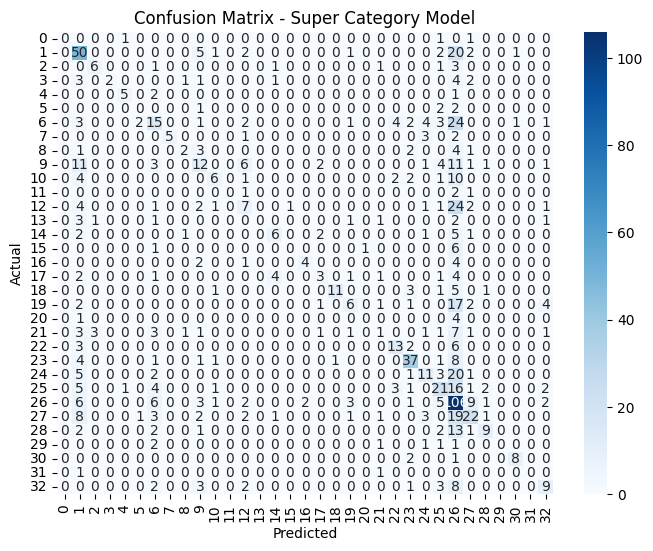

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
cm = confusion_matrix(y_super_test, pred_super)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_super_train),
            yticklabels=np.unique(y_super_train))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Super Category Model")
plt.show()

In [6]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

category_models = {}
category_label_encoders = {}

unique_super = np.unique(y_super)

for sc in unique_super:
    
    idx = np.where(y_super == sc)[0]

    # Filter embeddings and categories
    X_sc = np.array(X_emb)[idx]
    y_sc_global = y_cat[idx]

    # ---- Create LOCAL encoder for THIS super-category ----
    local_encoder = LabelEncoder()
    y_sc_local = local_encoder.fit_transform(y_sc_global)

    # ---- Train category model ----
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=5, max_depth=None)
    clf.fit(X_sc, y_sc_local)

    # ---- Store model + local encoder ----
    category_models[sc] = clf
    category_label_encoders[sc] = local_encoder

print("Fixed: Category classifier now restricted to SUPER CATEGORY only.")


Fixed: Category classifier now restricted to SUPER CATEGORY only.


In [ ]:
import joblib

save_data = {
    "category_models": category_models,
    "category_label_encoders": category_label_encoders,
    "model_super": model_super,
    "super_label_encoder": enc_super
}

joblib.dump(save_data, "category_hierarchical_models.pkl")
print("Saved hierarchical category classifiers successfully!")

Saved hierarchical category classifiers successfully!
